# Setup

In [1]:
import asyncio
from collections import Counter
import json
import re
from pathlib import Path

from googletrans import Translator
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import polars as pl
from sklearn.preprocessing import MinMaxScaler
import spacy
from stopwordsiso import stopwords
from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio
from wordcloud import WordCloud

import utils
from utils import PATHS

c:\Users\ola\miniconda3\envs\board_games_project\Lib\site-packages\stopwordsiso\_core.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ola\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Tools

In [3]:
def extract_tokens(text: str) -> list[str]:
    """Firstly remove all non alphabetic characters, having in mind that
    there are Unicode characters. After tokenization we remove stopwords (ENG)
    and  remove all 1-2 chars lenghts words.

    Finally lemmatize tokens.
    """
    clean = re.sub(r"[\W]+", " ", text.lower())
    clean = re.sub(r"[\d]+", " ", clean)
    words = nltk.word_tokenize(clean)
    words = [w for w in words if w not in stopwords("en") and len(w) > 2]
    doc = nlp(" ".join(words))
    return [token.lemma_.lower() for token in doc if token.is_alpha]

# Load

In [11]:
with (PATHS.data / "games_reviews.json").open("rb") as f:
    data = json.load(f)

In [12]:
with (PATHS.data / "games_reviews.json").open("rb") as f:
    data = json.load(f)

In [13]:
example_data = data[0]

In [14]:
example_data.keys()

dict_keys(['title', 'game_details', 'game_stats', 'game_reviews'])

In [18]:
Counter(extract_tokens(example_data["game_details"]["long_description"]))

Counter({'brass': 5,
         'industry': 5,
         'action': 5,
         'birmingham': 4,
         'game': 4,
         'build': 3,
         'network': 3,
         'canal': 3,
         'rail': 3,
         'story': 2,
         'predecessor': 2,
         'develop': 2,
         'establish': 2,
         'era': 2,
         'vps': 2,
         'tile': 2,
         'original': 2,
         'sell': 2,
         'loan': 2,
         'card': 2,
         'wild': 2,
         'economic': 1,
         'strategy': 1,
         'sequel': 1,
         'martin': 1,
         'wallace': 1,
         'masterpiece': 1,
         'tell': 1,
         'compete': 1,
         'entrepreneur': 1,
         'industrial': 1,
         'revolution': 1,
         'offer': 1,
         'arc': 1,
         'experience': 1,
         'effort': 1,
         'exploit': 1,
         'market': 1,
         'demand': 1,
         'play': 1,
         'halves': 1,
         'win': 1,
         'score': 1,
         'count': 1,
         'flip': 1,
 

In [19]:
def recognize_language(text: str) -> str:
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "en" #TODO: set special flag
    return lang

@utils.with_pickle_async()
async def translate_multiple(texts: list[str], lang_from: list[str], lang_to: list[str]) -> list[str]:
    async with Translator() as translator:
        async def translate_one(text, src, dest):
            t = await translator.translate(text=text, src=src, dest=dest)
            return t.text
        return await tqdm_asyncio.gather(
            *(translate_one(text, from_, to_) for text, from_, to_ in zip(texts, lang_from, lang_to, strict=True))
        )

In [20]:
example_game_reviews = [info["review"] for info in example_data["game_reviews"]]
from_langs =  [recognize_language(r) for r in example_game_reviews]
translactions = await translate_multiple(example_game_reviews, from_langs, ["en"] * len(from_langs), pickle_path=PATHS.pickles / "example_translations")

In [21]:
example_game_reviews

['2-4 [S]',
 'Great game that somehow feels simple, yet every decision you make carries weight\n',
 "If you can play this in 60 minutes you're playing too fast.  With my group a a game lasts about 45 minutes per player.\n\nKeep pushing up my rating..  This game continues to be my favorite and the favorite of our group.",
 'Tabletop',
 'I only played half a real game, but I was captivated throughout. Would play again.',
 'Ship',
 "The more I play, the more I realize it's more about playing the hand you're dealt, and less about strategy",
 'Very good game. I might not say it is the best of all times, but it is definetely great. The mechanics are simple, but I consider that it takes a little time to adapt to them. You may need several playthroughs to achieve some sort of mastering. Revise every victory point possibility to plan your strategy, otherwise, it can be easy to fall pursuing things that are not profitable in the long term.',
 "+ Artwork is great\n+ Great strategy game\n+ Lots of

In [22]:
translactions

["{'review': '2-4 [S]', 'reviewer_country': 'Italy', 'rating': 0.0, 'date': '2025-09-24 17:47:08', 'is_owner': True}",
 "{'review': 'Great game that somehow feels simple, yet every decision you make carries weight\\n', 'reviewer_country': '', 'rating': 8.5, 'date': '2021-02-25 08:42:44', 'is_owner': False}",
 '{\'review\': "If you can play this in 60 minutes you\'re playing too fast.  With my group a a game lasts about 45 minutes per player.\\n\\nKeep pushing up my rating..  This game continues to be my favorite and the favorite of our group.", \'reviewer_country\': \'United States\', \'rating\': 9.4, \'date\': \'2024-07-10 16:55:53\', \'is_owner\': True}',
 "{'review': 'Tabletop', 'reviewer_country': 'United States', 'rating': 0.0, 'date': '2025-02-01 17:35:35', 'is_owner': True}",
 "{'review': 'I only played half a real game, but I was captivated throughout. Would play again.', 'reviewer_country': 'United States', 'rating': 8.7, 'date': '2025-11-10 19:17:57', 'is_owner': False}",
 "{

In [23]:
def extract_tokens(text: str) -> list[str]:
    """Firstly remove all non alphabetic characters, having in mind that
    there are Unicode characters. After tokenization we remove stopwords (ENG+PL)
    and  remove all 1-2 chars lenghts words.

    Finally lemmatize tokens.
    """
    clean = re.sub(r"[\W]+", " ", text.lower())
    clean = re.sub(r"[\d]+", " ", clean)
    words = nltk.word_tokenize(clean)
    words = [w for w in words if w not in (word_difficulty.STOPWORDS_PL | word_difficulty.STOPWORDS_EN) and len(w) > 2]
    doc = nlp(" ".join(words))
    return [token.lemma_.lower() for token in doc if token.is_alpha]

### Sentiment analysis

In [24]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        sentiment = 1
    elif scores['compound'] <= -0.05:
        sentiment = -1
    else:
        sentiment = 0
    return sentiment

In [25]:
sentiments = list(map(get_sentiment, translactions))
list(zip(sentiments, translactions))

[(0,
  "{'review': '2-4 [S]', 'reviewer_country': 'Italy', 'rating': 0.0, 'date': '2025-09-24 17:47:08', 'is_owner': True}"),
 (1,
  "{'review': 'Great game that somehow feels simple, yet every decision you make carries weight\\n', 'reviewer_country': '', 'rating': 8.5, 'date': '2021-02-25 08:42:44', 'is_owner': False}"),
 (1,
  '{\'review\': "If you can play this in 60 minutes you\'re playing too fast.  With my group a a game lasts about 45 minutes per player.\\n\\nKeep pushing up my rating..  This game continues to be my favorite and the favorite of our group.", \'reviewer_country\': \'United States\', \'rating\': 9.4, \'date\': \'2024-07-10 16:55:53\', \'is_owner\': True}'),
 (1,
  "{'review': 'Tabletop', 'reviewer_country': 'United States', 'rating': 0.0, 'date': '2025-02-01 17:35:35', 'is_owner': True}"),
 (1,
  "{'review': 'I only played half a real game, but I was captivated throughout. Would play again.', 'reviewer_country': 'United States', 'rating': 8.7, 'date': '2025-11-10 1

# Unsupervised Text Classification

In [27]:
import pandas as pd

In [ ]:
import polars as pl
from sklearn.datasets import fetch_20newsgroups

# load data
train = fetch_20newsgroups(subset='train', shuffle=False)
test = fetch_20newsgroups(subset='test', shuffle=False)

# parse data to pandas DataFrames
newsgroup_test = pd.DataFrame({'article':test.data, 'class_index':test.target})
newsgroup_train = pd.DataFrame({'article':train.data, 'class_index':train.target})

# load labels with keywords
# labels = pd.read_csv('20newsgroups_keywords.csv',sep=';')
labels = pd.DataFrame({
    "class_index": range(len(train.target_names)),
    "class_name": train.target_names
})

# Sentiment analysis

In [ ]:
import json
import re


### Loading

In [ ]:
def clean_for_sentiment(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
with open("data//games_reviews.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [ ]:
rows = []
for game in data:
    game_title = game["title"]
    game_weight = float(game["game_details"]["params"]["weight"])
    avg_game_rating = game["game_stats"]["avg_rating"]

    for review in game["game_reviews"]:
        text = review.get("review", "").strip()

        # skip empty or useless reviews
        if len(text) < 20:
            continue
        rows.append({
            "game_title": game_title,
            "game_weight": game_weight,
            "avg_game_rating": avg_game_rating,
            "review_text": text,
            "review_rating": review.get("rating"),
            "is_owner": review.get("is_owner"),
            "review_date": review.get("date")
        })

df = pd.DataFrame(rows)

### Language detection - commented, long

In [ ]:
def safe_lang_detect(text):
    try:
        return recognize_language(text)
    except:
        return "unknown"

#df["lang"] = df["review_text"].apply(safe_lang_detect)
#to_translate = df[df["lang"] != "en"]
#df = df[df["lang"] == "en"]

In [176]:
async def translate_reviews(df):
    reviews = df["review_text"].tolist()
    from_langs = df["lang"].tolist()

    translations = await translate_multiple(
        reviews,
        from_langs,
        ["en"] * len(from_langs),
        pickle_path=PATHS.pickles / "df_translations"
    )
    return translations

In [177]:
from googletrans import Translator

def translate_multiple(texts, src_langs, tgt_langs):
    translator = Translator()
    results = []

    for text, src, tgt in zip(texts, src_langs, tgt_langs):
        try:
            if src == "en":
                results.append(text)
            else:
                t = translator.translate(text, src=src, dest=tgt)
                results.append(t.text)
        except Exception:
            results.append(text)  # fallback

    return results

In [227]:
# translations = translate_multiple(
#     reviews,
#     from_langs,
#     ["en"] * len(from_langs)
# )

#df.loc[to_translate.index, "review_en"] = translations

## Sentiment analysis
textblob - chyba niepotrzebne, jeśli za mało na prezentacji to może porównanie?

In [178]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

C:\Users\ola\AppData\Local\Temp\ipykernel_45812\4230582071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")


In [179]:
df = df[df["review_rating"].notna()]

In [180]:
print("Total reviews:", len(df))
print("Unique games:", df["game_title"].nunique())
print("Average review length:",
      df["review_text"].str.len().mean())

Total reviews: 307644
Unique games: 100
Average review length: 264.4252187593452


In [209]:
def vader_label(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"
def textblob_label(polarity, pos=0.05, neg=-0.05):
    if polarity > pos:
        return "positive"
    elif polarity < neg:
        return "negative"
    else:
        return "neutral"


In [182]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df["sentiment_scores"] = df["review_text"].apply(sia.polarity_scores)
df["compound"] = df["sentiment_scores"].apply(lambda x: x["compound"])
df["sentiment_label"] = df["compound"].apply(vader_label)

In [208]:
from textblob import TextBlob

df["tb_sentiment"] = df["review_text"].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

In [ ]:
df["tb_subjectivity"] = df["review_text"].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

df["tb_label"] = df["tb_polarity"].apply(textblob_label)

### Plots

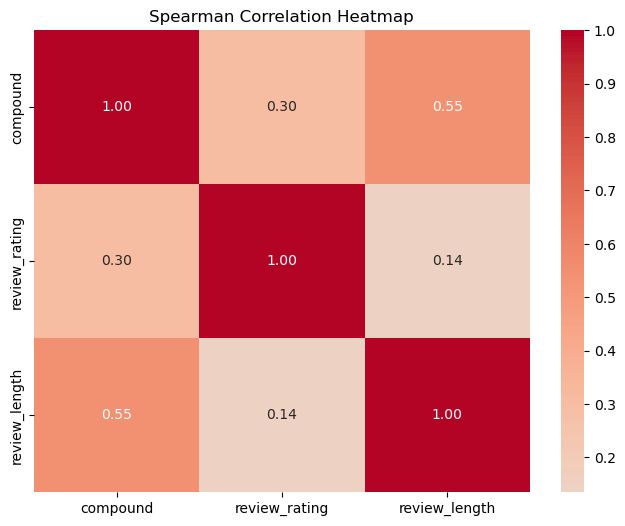

In [228]:
# correlation for numeric features
numeric_cols = [
    "compound",
    "review_rating",
    "review_length"
]

corr_matrix = df[numeric_cols].corr(method="spearman")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [229]:
# reviews that may be misclassified
contradictions = df[
    ((df["review_rating"] >= 8) & (df["compound"] < 0)) |
    ((df["review_rating"] <= 3) & (df["compound"] > 0))
]
contradictions

,game_title,game_weight,avg_game_rating,review_text,review_rating,is_owner,review_date,lang,sentiment_scores,compound,...,length_bin,tb_sentiment,rules_sentiment,complexity_sentiment,components_sentiment,replayability_sentiment,year,tb_polarity,tb_subjectivity,tb_label
22,Brass: Birmingham,3.87,8.572,I enjoy Lancashire and want to add this one to...,0.0,False,2024-11-08 11:08:43,en,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.5423,...,"(50, 100]",0.400000,NaN,NaN,NaN,NaN,2024.0,0.400000,0.500000,positive
26,Brass: Birmingham,3.87,8.572,+ Engaging tactics and strategy\n+ Agonizing d...,8.0,False,2025-08-24 07:20:11,en,"{'neg': 0.147, 'neu': 0.757, 'pos': 0.096, 'co...",-0.3182,...,"(100, 200]",0.110714,-0.3182,NaN,NaN,NaN,2025.0,0.110714,0.492857,positive
37,Brass: Birmingham,3.87,8.572,"In my opinion, Lancashire is much better.\n\nL...",0.0,False,2018-10-26 17:42:27,en,"{'neg': 0.025, 'neu': 0.777, 'pos': 0.198, 'co...",0.8835,...,"(200, 500]",0.106071,NaN,NaN,NaN,NaN,2018.0,0.106071,0.581071,positive
60,Brass: Birmingham,3.87,8.572,I enjoy Lancashire and want to add this one to...,0.0,False,2024-11-08 11:08:43,en,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.5423,...,"(50, 100]",0.400000,NaN,NaN,NaN,NaN,2024.0,0.400000,0.500000,positive
64,Brass: Birmingham,3.87,8.572,+ Engaging tactics and strategy\n+ Agonizing d...,8.0,False,2025-08-24 07:20:11,en,"{'neg': 0.147, 'neu': 0.757, 'pos': 0.096, 'co...",-0.3182,...,"(100, 200]",0.110714,-0.3182,NaN,NaN,NaN,2025.0,0.110714,0.492857,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360587,Final Girl,2.74,8.248,solo - seems super versitile - the art looks g...,0.0,False,2024-06-16 15:32:57,en,"{'neg': 0.065, 'neu': 0.396, 'pos': 0.539, 'co...",0.9712,...,"(100, 200]",0.000000,NaN,NaN,0.9712,NaN,2024.0,0.000000,0.736111,neutral
360591,Final Girl,2.74,8.248,Thematically amazing. Very luck based and the ...,0.0,True,2022-11-30 01:59:46,en,"{'neg': 0.133, 'neu': 0.588, 'pos': 0.279, 'co...",0.8130,...,"(200, 500]",0.311111,0.8020,NaN,0.3740,NaN,2022.0,0.311111,0.711111,positive
360602,Final Girl,2.74,8.248,Played twice. Solo only,0.0,True,2023-02-13 18:32:47,en,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.3400,...,"(0, 50]",0.000000,NaN,NaN,NaN,NaN,2023.0,0.000000,1.000000,neutral
360603,Final Girl,2.74,8.248,https://www.vanrydergames.com/new-products/fin...,0.0,True,2022-01-05 11:16:12,en,"{'neg': 0.07, 'neu': 0.832, 'pos': 0.098, 'com...",0.5204,...,"(200, 500]",0.033333,NaN,NaN,NaN,NaN,2022.0,0.033333,0.875000,neutral


In [ ]:
# podział na tytuły gier
game_sentiment = (
    df.groupby("game_title")
      .agg(
          mean_sentiment=("compound", "mean"),
          game_weight=("game_weight", "first"),
          review_count=("compound", "count")
      )
      .reset_index()
)
game_sentiment


,game_title,mean_sentiment,game_weight,review_count
0,7 Wonders Duel,0.517256,2.23,7641
1,A Feast for Odin,0.480376,3.86,3037
2,Age of Innovation,0.522500,4.26,608
3,Agricola,0.465439,3.64,9213
4,Agricola (Revised Edition),0.451831,3.44,1574
...,...,...,...,...
95,Viticulture Essential Edition,0.491299,2.90,4280
96,Voidfall,0.457948,4.59,839
97,War of the Ring: Second Edition,0.418722,4.22,2604
98,Wingspan,0.565457,2.48,8904


<Axes: xlabel='game_weight', ylabel='mean_sentiment'>

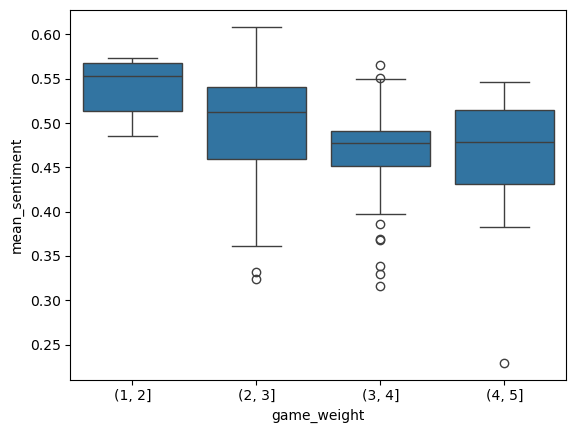

In [230]:
# game difficulty(?) vs sentiment
sns.boxplot(
    data=game_sentiment,
    x=pd.cut(game_sentiment["game_weight"], [1,2,3,4,5]),
    y="mean_sentiment"
)

<Axes: xlabel='game_weight', ylabel='mean_sentiment'>

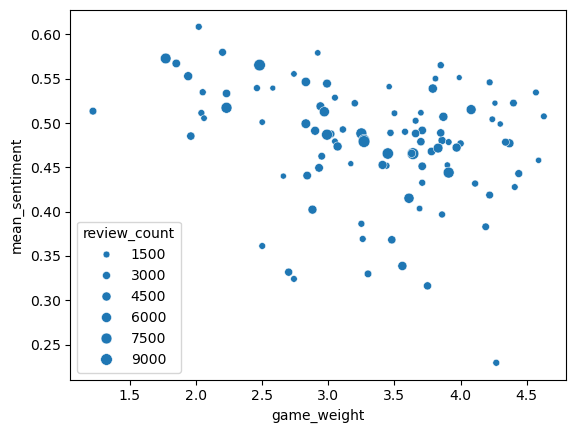

In [192]:
sns.scatterplot(
    data=game_sentiment,
    x="game_weight",
    y="mean_sentiment",
    size="review_count"
)

<Axes: xlabel='compound', ylabel='Count'>

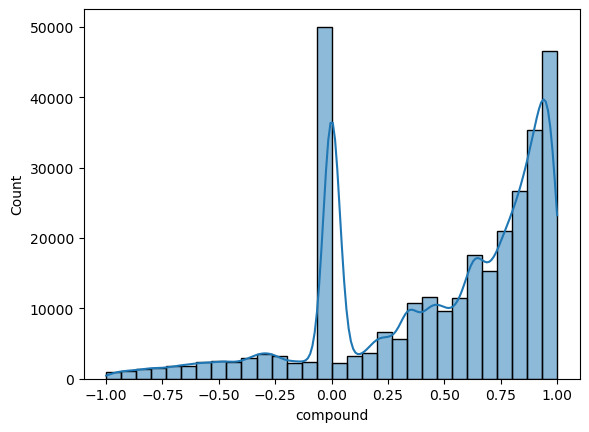

In [ ]:
# distribution of sentiment compound
sns.histplot(df["compound"], bins=30, kde=True)

<Axes: xlabel='rating_bin', ylabel='compound'>

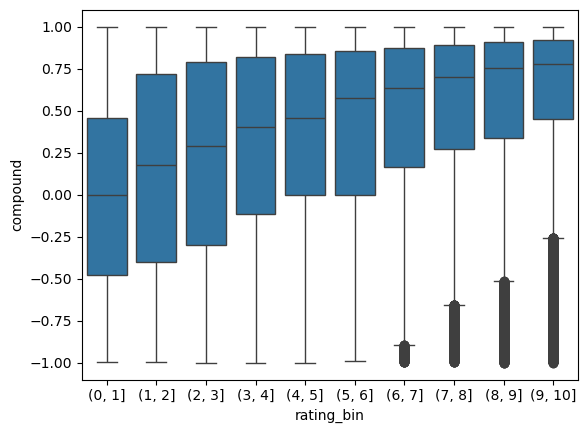

In [ ]:
# given rating vs sentiment
df["rating_bin"] = pd.cut(
    df["review_rating"],
    bins=np.arange(11)
)

sns.boxplot(data=df, x="rating_bin", y="compound")

C:\Users\ola\AppData\Local\Temp\ipykernel_45812\2950181266.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["rating_group", "sentiment_label"])


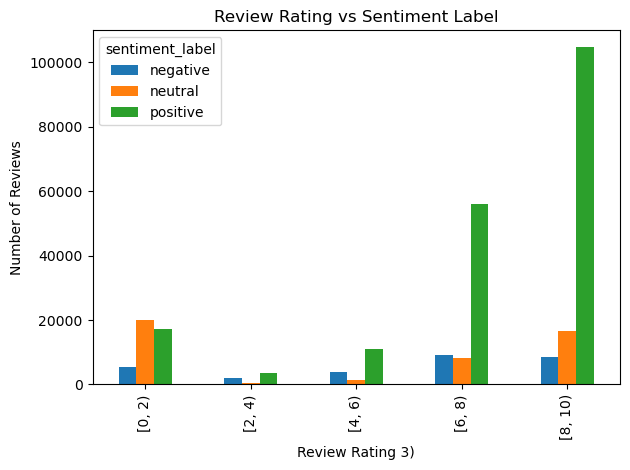

In [ ]:
# same but just label - > clearer plot?
df["rating_group"] = pd.cut(
    df["review_rating"],
    bins=range(int(df["review_rating"].min()),
               int(df["review_rating"].max()) + 2, 2),
    right=False
)
counts = (
    df.groupby(["rating_group", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
)
counts.plot(kind="bar")

plt.xlabel("Review Rating 3)")
plt.ylabel("Number of Reviews")
plt.title("Review Rating vs Sentiment Label")
plt.tight_layout()
plt.show()

<Axes: xlabel='is_owner', ylabel='compound'>

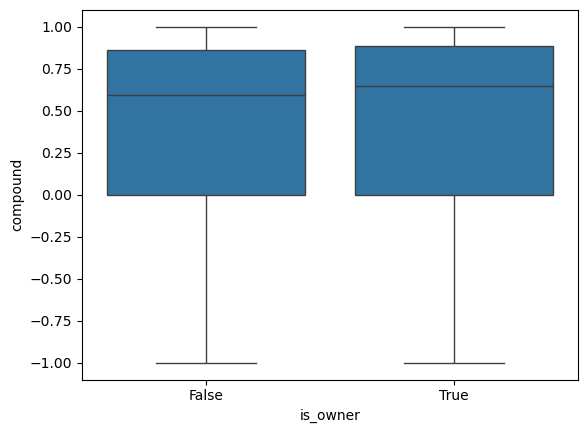

In [ ]:
# game ownership vs sentiment
sns.boxplot(data=df, x="is_owner", y="compound")

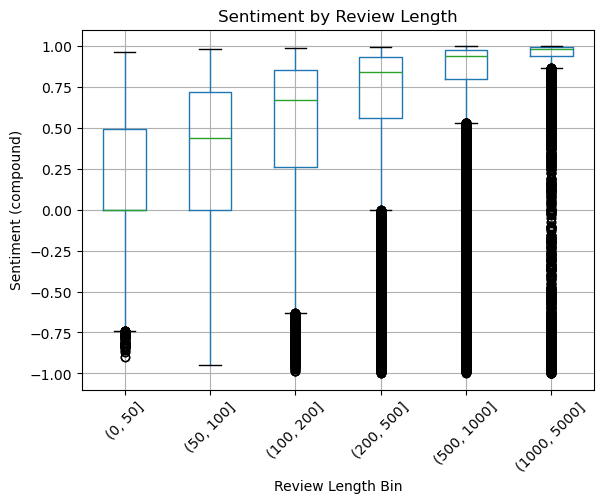

In [225]:
df["length_bin"] = pd.cut(
    df["review_length"],
    bins=[0, 50, 100, 200, 500, 1000, 5000]
)

df.boxplot(column="compound", by="length_bin", rot=45)
plt.xlabel("Review Length Bin")
plt.ylabel("Sentiment (compound)")
plt.title("Sentiment by Review Length")
plt.suptitle("")
plt.show()

<Axes: xlabel='review_length', ylabel='compound'>

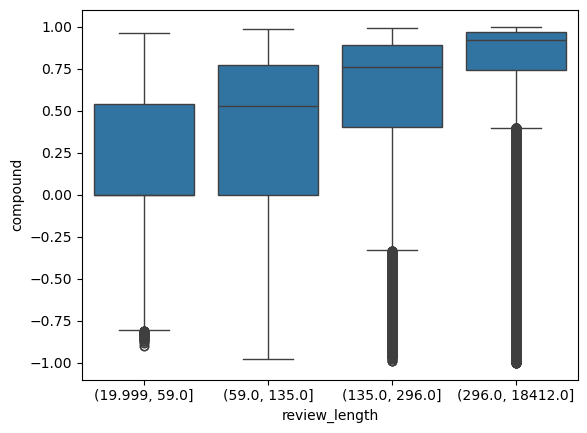

In [199]:
sns.boxplot(
    data=df,
    x=pd.qcut(df["review_length"], 4),
    y="compound"
)

<Axes: xlabel='mean_sentiment', ylabel='game_title'>

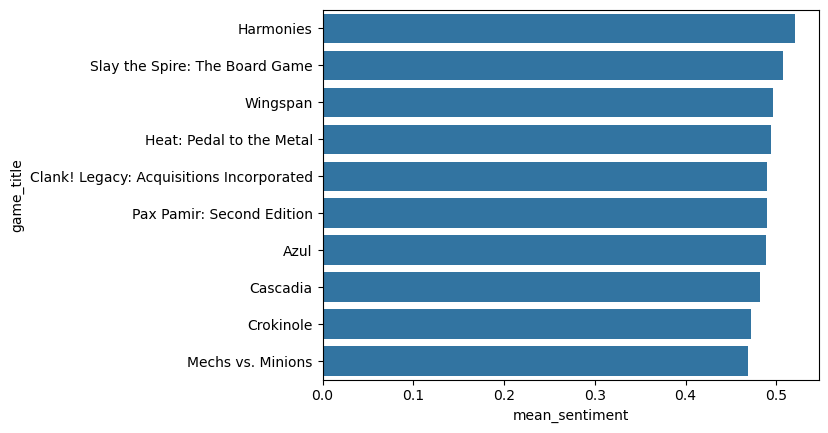

In [ ]:
# chyba zbyt szcegółowe, nie znamy się tak na grach?
top_games = game_sentiment.sort_values(
    "mean_sentiment", ascending=False
).head(10)

sns.barplot(
    data=top_games,
    x="mean_sentiment",
    y="game_title"
)

In [219]:
yearly = (
    df.groupby("year")
      .agg(
          mean_compound=("compound", "mean"),
          total=("sentiment_label", "size"),
          pos=("sentiment_label", lambda x: (x == "positive").sum()),
          neu=("sentiment_label", lambda x: (x == "neutral").sum()),
          neg=("sentiment_label", lambda x: (x == "negative").sum()),
      )
      .reset_index()
)

# convert counts to percentages
yearly["pos_pct"] = yearly["pos"] / yearly["total"] * 100
yearly["neu_pct"] = yearly["neu"] / yearly["total"] * 100
yearly["neg_pct"] = yearly["neg"] / yearly["total"] * 100

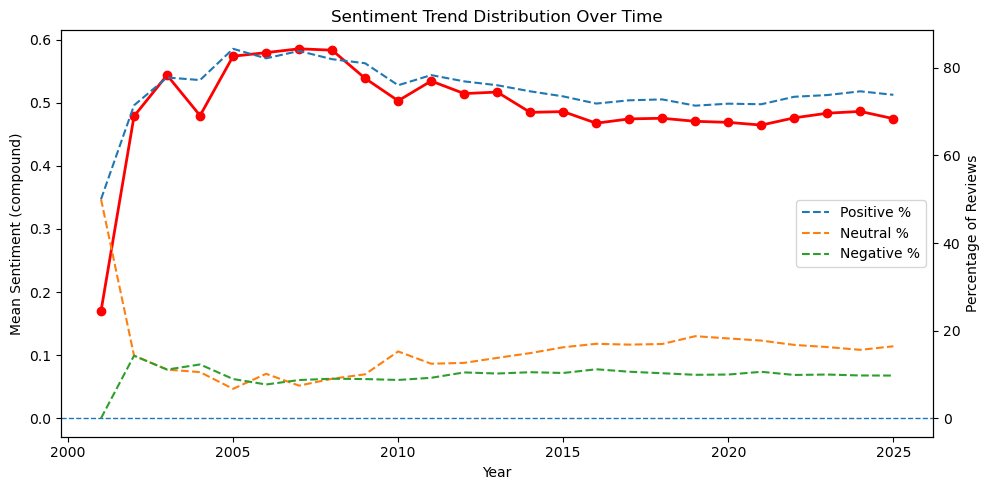

In [223]:


fig, ax1 = plt.subplots(figsize=(10, 5))

# Mean compound sentiment
ax1.plot(yearly["year"], yearly["mean_compound"], marker="o", label="mean sentiment", lw=2, c='red')
ax1.set_ylabel("Mean Sentiment (compound)")
ax1.set_xlabel("Year")
ax1.axhline(0, linestyle="--", linewidth=1)

# Second axis for percentages
ax2 = ax1.twinx()
ax2.plot(yearly["year"], yearly["pos_pct"], linestyle="--", label="Positive %")
ax2.plot(yearly["year"], yearly["neu_pct"], linestyle="--", label="Neutral %")
ax2.plot(yearly["year"], yearly["neg_pct"], linestyle="--", label="Negative %")
ax2.set_ylabel("Percentage of Reviews")

ax2.legend()
plt.title("Sentiment Trend Distribution Over Time")
plt.tight_layout()
plt.show()
